# Analysis of Twitter Data
## Data Visualisation Basics
A picture is worth a thousand tweets: more often than not, designing a good visual representation of our data, can help us make sense of them and highlight interesting insights. After collecting and analysing Twitter data, we will now continue with some notions on data visualisation with Python.

### From Python to Javascript with Vincent
While there are some options to create plots in Python using libraries like matplotlib or ggplot, one of the coolest libraries for data visualisation is probably **D3.js** which is, as the name suggests, based on Javascript. D3 plays well with web standards like CSS and SVG, and allows to create some wonderful interactive visualisations.

*Vincent* bridges the gap between a Python back-end and a front-end that supports D3.js visualisation, allowing us to benefit from both sides. The tagline of Vincent is in fact “*The data capabilities of Python. The visualization capabilities of JavaScript*”. Vincent, a Python library, takes our data in Python format and translates them into *Vega*, a JSON-based visualisation grammar that will be used on top of D3. It sounds quite complicated, but it’s fairly simple and pythonic. You don’t have to write a line in Javascript/D3 if you don’t want to.

Firstly, let’s install Vincent:

Secondly, let’s create our first plot. Using the list of most frequent terms (without hashtags) from our provious data set, we want to plot their frequencies:

In [1]:
# from the old code
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

import json
from collections import Counter

from nltk.corpus import stopwords
import string
 
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

fname = "tweets.json"
with open(fname, 'r') as f:
    count_terms_only = Counter()
    for line in f:
        tweet = json.loads(line)
        # substitute, e.g. \u2026, with space
        tw = re.sub(r'[^\x00-\x7F]+',' ', tweet['text'])
        # Count terms only (no hashtags, no mentions)
        terms_only = [term for term in preprocess(tw)\
              if term not in stop and\
              not term.startswith(('#', '@'))]         
        # Update the counter
        count_terms_only.update(terms_only)
    # Print the first 10 most frequent words
    #print(count_terms_only.most_common(10))

# new code begins here
import vincent
 
word_freq = count_terms_only.most_common(20)
labels, freq = zip(*word_freq)
data = {'data': freq, 'x': labels}
bar = vincent.Bar(data, iter_idx='x')
bar.to_json('term_freq.json')

At this point, the file term_freq.json will contain a description of the plot that can be handed over to D3.js and Vega. A simple template (taken from Vincent resources) to visualise the plot:

Save the above HTML page as **chart.html** and run the simple Python web server:

Now you can open your browser at http://localhost:8889/chart.html and observe the result.

Notice that you could save the HTML template directly from Python with:

In [2]:
bar.to_json('term_freq.json', html_out=True, html_path='chart.html')

## Time Series Visualisation

Another interesting aspect of analysing data from Twitter is the possibility to observe the distribution of tweets over time. In other words, if we organise the frequencies into temporal buckets, we could observe how Twitter users react to real-time events.

One of our favourite tools for data analysis with Python is Pandas, which also has a fairly decent support for time series. As an example, let’s track the hashtag #bigdata to observe what happened during the first match.

In the main loop which reads all the tweets, we simply track the occurrences of the hashtag, i.e. we can refactor the code from the previous episodes into something similar to:

In [3]:
import pandas
import json
import sys
 
dates_BIGDATA = []

fname = "C:\\Users\\knotsupavit\\Desktop\\jupyter\\tweets_bigData_dataAnalytic.json"
f = open(fname, 'r')
# f is the file pointer to the JSON data set
count = 1
for line in f:
    count = count + 1
    if count%500 == 0:
        sys.stdout.write('.')
    if count%35000 == 0:
        sys.stdout.write('\n')
    tweet = json.loads(line)
    # substitute, e.g. \u2026, with space
    tw = re.sub(r'[^\x00-\x7F]+',' ', tweet['text'])
    # let's focus on hashtags only at the moment
    terms_hash = [term for term in preprocess(tw) if term.startswith('#')]
    # track when the hashtag is mentioned
    if '#bigdata' in terms_hash:
        dates_BIGDATA.append(tweet['created_at'])
print '\nDone..'
 
# a list of "1" to count the hashtags
ones = [1]*len(dates_BIGDATA)
# the index of the series
idx = pandas.DatetimeIndex(dates_BIGDATA)
# the actual series (at series of 1s for the moment)
BIGDATA = pandas.Series(ones, index=idx)
 
# Resampling / bucketing
per_10minute = BIGDATA.resample('10Min').sum().fillna(0)

......................................................................
......................................................................
.............................................
Done..


The last line is what allows us to track the frequencies over time. The series is re-sampled with intervals of 10 minutes. This means all the tweets falling within a particular minute will be aggregated, more precisely they will be summed up. The time index will not keep track of the seconds anymore. If there is no tweet in a particular minute, the *fillna()* function will fill the blanks with zeros.

To put the time series, run these commands:

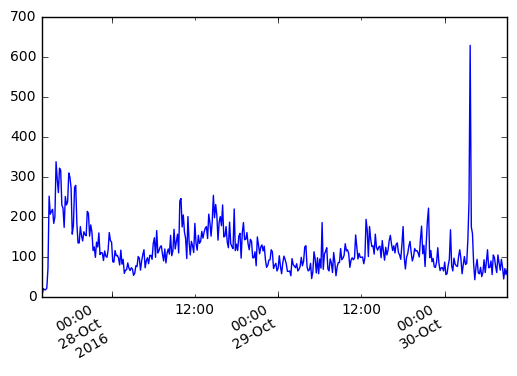

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
per_10minute.plot()
plt.gcf().autofmt_xdate()
plt.show()

Rather than just observing one sequence at a time, we could compare different series to observe how the matches has evolved. 

So let’s refactor the code for the time series, keeping track of the three different hashtags #bigdata, #datascience and #python (<-- your turn to modify the code) into the corresponding pandas.Series.

In [6]:
import pandas
import json
import sys
 
dates_BIGDATA = []
dates_DATASCIENCE = []

fname = "C:\\Users\\knotsupavit\\Desktop\\jupyter\\tweets_bigData_dataAnalytic.json"
f = open(fname, 'r')
# f is the file pointer to the JSON data set
count = 1
for line in f:
    count = count + 1
    if count%500 == 0:
        sys.stdout.write('.')
    if count%35000 == 0:
        sys.stdout.write('\n')
    tweet = json.loads(line)
    # substitute, e.g. \u2026, with space
    tw = re.sub(r'[^\x00-\x7F]+',' ', tweet['text'])
    # let's focus on hashtags only at the moment
    terms_hash = [term for term in preprocess(tw) if term.startswith('#')]
    # track when the hashtag is mentioned
    if '#bigdata' in terms_hash:
        dates_BIGDATA.append(tweet['created_at'])
    if '#datascience' in terms_hash:
        dates_DATASCIENCE.append(tweet['created_at'])

print '\nwait..'
# a list of "1" to count the hashtags
ones = [1]*len(dates_BIGDATA)
# the index of the series
idx = pandas.DatetimeIndex(dates_BIGDATA)
# the actual series (at series of 1s for the moment)
BIGDATA = pandas.Series(ones, index=idx)
# Resampling / bucketing
bd_per_minute = BIGDATA.resample('1Min').sum().fillna(0)

ones = [1]*len(dates_DATASCIENCE)
# the index of the series
idx = pandas.DatetimeIndex(dates_DATASCIENCE)
# the actual series (at series of 1s for the moment)
DATASCIENCE = pandas.Series(ones, index=idx)
# Resampling / bucketing
ds_per_minute = DATASCIENCE.resample('1Min').sum().fillna(0)
print 'Done..'

......................................................................
......................................................................
.............................................
wait..
Done..


In [7]:
# all the data together
match_data = dict(BigData=bd_per_minute, DataScience=ds_per_minute)
# we need a DataFrame, to accommodate multiple series
all_matches = pandas.DataFrame(data=match_data,
                               index=bd_per_minute.index)
# Resampling as above
all_matches = all_matches.resample('10Min').sum().fillna(0)


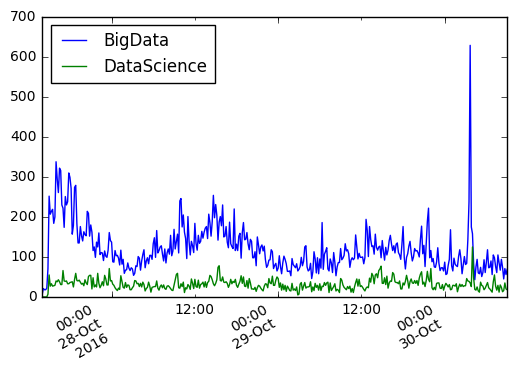

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
all_matches.plot()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
## Your turn now
## Rather than obeserve the hastags, 
## modify the code to observe the co-occurrences,
## such as 'big data', 'data science', ...



In [12]:
import pandas
import json
import sys
 
dates_BIGDATA = []
dates_DATASCIENCE = []

fname = "C:\\Users\\knotsupavit\\Desktop\\jupyter\\tweets_bigData_dataAnalytic.json"
f = open(fname, 'r')
# f is the file pointer to the JSON data set
count = 1
for line in f:
    count = count + 1
    if count%500 == 0:
        sys.stdout.write('.')
    if count%35000 == 0:
        sys.stdout.write('\n')
    tweet = json.loads(line)
    # substitute, e.g. \u2026, with space
    tw = re.sub(r'[^\x00-\x7F]+',' ', tweet['text'])
    # let's focus on hashtags only at the moment
    terms_hash = [term for term in preprocess(tw)]
    # track when the hashtag is mentioned
    if 'big' in terms_hash:
        if 'data' in terms_hash:
            dates_BIGDATA.append(tweet['created_at'])
    if 'data' in terms_hash:
        if 'science' in terms_hash:
            dates_DATASCIENCE.append(tweet['created_at'])

print '\nwait..'
# a list of "1" to count the hashtags
ones = [1]*len(dates_BIGDATA)
# the index of the series
idx = pandas.DatetimeIndex(dates_BIGDATA)
# the actual series (at series of 1s for the moment)
BIGDATA = pandas.Series(ones, index=idx)
# Resampling / bucketing
bd_per_minute = BIGDATA.resample('10Min').sum().fillna(0)

ones = [1]*len(dates_DATASCIENCE)
# the index of the series
idx = pandas.DatetimeIndex(dates_DATASCIENCE)
# the actual series (at series of 1s for the moment)
DATASCIENCE = pandas.Series(ones, index=idx)
# Resampling / bucketing
ds_per_minute = DATASCIENCE.resample('10Min').sum().fillna(0)
print 'Done..'

......................................................................
......................................................................
.............................................
wait..
Done..


In [14]:
print dates_BIGDATA, dates_DATASCIENCE

[u'Thu Oct 27 14:06:29 +0000 2016', u'Thu Oct 27 14:06:38 +0000 2016', u'Thu Oct 27 14:06:42 +0000 2016', u'Thu Oct 27 14:06:43 +0000 2016', u'Thu Oct 27 14:06:48 +0000 2016', u'Thu Oct 27 14:06:50 +0000 2016', u'Thu Oct 27 14:06:55 +0000 2016', u'Thu Oct 27 14:06:55 +0000 2016', u'Thu Oct 27 14:07:01 +0000 2016', u'Thu Oct 27 14:07:11 +0000 2016', u'Thu Oct 27 14:07:17 +0000 2016', u'Thu Oct 27 14:07:19 +0000 2016', u'Thu Oct 27 14:07:36 +0000 2016', u'Thu Oct 27 14:07:40 +0000 2016', u'Thu Oct 27 14:07:41 +0000 2016', u'Thu Oct 27 14:07:41 +0000 2016', u'Thu Oct 27 14:07:47 +0000 2016', u'Thu Oct 27 14:07:47 +0000 2016', u'Thu Oct 27 14:07:59 +0000 2016', u'Thu Oct 27 14:08:03 +0000 2016', u'Thu Oct 27 14:08:06 +0000 2016', u'Thu Oct 27 14:08:08 +0000 2016', u'Thu Oct 27 14:08:09 +0000 2016', u'Thu Oct 27 14:08:17 +0000 2016', u'Thu Oct 27 14:08:20 +0000 2016', u'Thu Oct 27 14:08:28 +0000 2016', u'Thu Oct 27 14:08:36 +0000 2016', u'Thu Oct 27 14:08:38 +0000 2016', u'Thu Oct 27 14:08:

In [15]:
# all the data together
match_data = dict(BigData=bd_per_minute, DataScience=ds_per_minute)
# we need a DataFrame, to accommodate multiple series
all_matches = pandas.DataFrame(data=match_data,
                               index=bd_per_minute.index)
# Resampling as above
all_matches = all_matches.resample('10Min').sum().fillna(0)


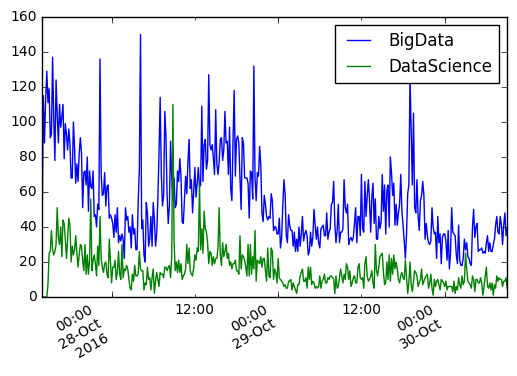

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
all_matches.plot()
plt.gcf().autofmt_xdate()
plt.show()